<b><h2>Decison Trees - Using a Decison tree to detemine if it will rain in Dun Laoghaire</h2></b><br>
For this I will be using Skit-learn and MetEirean Data. I extracted a daily weather report from my nearest weather station in Dun Loaghaire, County Dublin. <br> This was then filtered to only look at data for 2016 and saved as a CSV file.<br>
The objective of this is to predict if - given a set of inputs - if we can predict rainfall with any accuracy - using a training data set. <br>
<br> I addded a column in the data file to document the target question - 'Did it rain on the date in question?'  1 for Yes and 0 for No
<bR>
Firstly we will import and inspect the data using Pandas. 


In [28]:
import numpy as np
import pandas as pd
from sklearn import tree
import seaborn as sns

%matplotlib inline

input_file = "C:\Users\Glandore\Desktop\Github\Dun_Laoghaire_2016.csv"
df = pd.read_csv(input_file, header = 0)

Lets check the data and see what we have to work with..this can be done using the head method.

In [29]:
df.head(5)

,Date,ind,rain,ind.1,maxt,ind.2,mint,gmin,soil,It_Rained
0,01-jan-2016,0,23.5,0,9.8,0,1.5,-3.0,5.5,1
1,02-jan-2016,0,7.5,0,10.2,0,5.8,4.0,7.9,1
2,03-jan-2016,0,1.7,0,9.6,0,5.2,1.9,7.9,1
3,04-jan-2016,0,20.0,0,8.1,0,3.9,-1.4,6.7,1
4,05-jan-2016,0,10.5,0,7.8,0,3.6,3.0,6.9,1


We then can look at the data using the describe method

In [30]:
df.describe()

,ind,rain,ind.1,maxt,ind.2,mint,gmin,It_Rained
count,366.000000,366.000000,366.0,366.000000,366.000000,366.000000,366.000000,366.000000
mean,1.103825,1.782514,0.0,13.759563,0.005464,7.940437,5.274044,0.551913
std,1.790427,4.045382,0.0,4.824249,0.073821,4.390813,5.048565,0.497979
min,0.000000,0.000000,0.0,4.600000,0.000000,-0.100000,-5.400000,0.000000
25%,0.000000,0.000000,0.0,9.800000,0.000000,4.025000,1.100000,0.000000
50%,0.000000,0.100000,0.0,13.300000,0.000000,8.150000,5.450000,1.000000
75%,4.000000,1.975000,0.0,17.600000,0.000000,11.600000,9.500000,1.000000
max,4.000000,32.600000,0.0,25.500000,1.000000,18.000000,16.700000,1.000000


Looking at this data set we need to remove some redundant columns and round the values to whole numbers as this will reduce the number of model values. A decision tree needs numeric vales to work. This can be done using Pandas using the drop command

In [38]:
df = df.drop('ind', 1)
df = df.drop('ind.1', 1)
df = df.drop('ind.2', 1)
df = df.drop('gmin', 1)
df = df.drop('soil', 1)

Lets check the data set again using head

In [39]:
df.head(5)

,Date,rain,maxt,mint,It_Rained
0,2016-01-01,23,9,1,1
1,2016-01-02,7,10,5,1
2,2016-01-03,1,9,5,1
3,2016-01-04,20,8,3,1
4,2016-01-05,10,7,3,1


We will do some basic charting the try and look at the data from a visiual point of view. The Seaborn pair plot takes all the numeric based values and then plots them against each other. This way we can easily see if there is a correlation or pattern in the data. The "Hue" command colurs the chart by the target value.

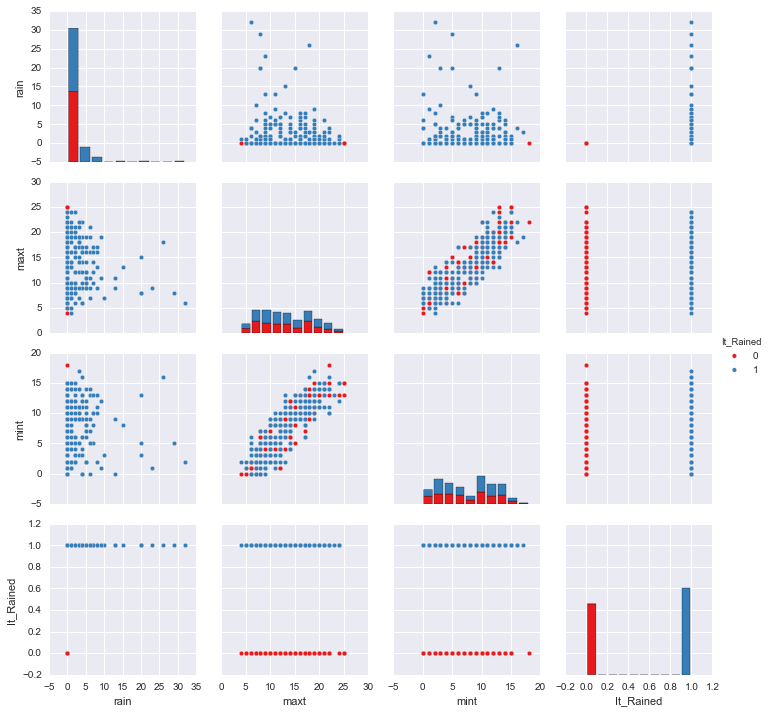

In [40]:
sns.pairplot(df,hue='It_Rained',palette='Set1')

We will want to do some time series analysis so I want to make sure the dates are in good formats. We ca use the Pandas function to_datetime for this. Using dytpes method we see that the date is an object and not a date value so it needs to be fixed.

In [41]:
df.dtypes

Date         datetime64[ns]
rain                  int32
maxt                  int32
mint                  int32
It_Rained             int64
dtype: object

Convert the whole column to see the default date type.

In [42]:
df['Date'] =  pd.to_datetime(df['Date'])

Lets look at the data again - it now has a proper date format

In [43]:
df.dtypes

Date         datetime64[ns]
rain                  int32
maxt                  int32
mint                  int32
It_Rained             int64
dtype: object

Scikit-learn needs everything to be numerical for decision trees to work. So, so to make things a bit simpler we will convert all the numbers to whole numbers. This can be done using the astype method.

Looking at the raw data i notice there a few blank values which can cuase trouble later on so it is best to replace blanks with 0 using the fillna method. I also need to remove spaces from this column as it occurs in several places.


In [44]:
df.fillna(value=0).head(5)

,Date,rain,maxt,mint,It_Rained
0,2016-01-01,23,9,1,1
1,2016-01-02,7,10,5,1
2,2016-01-03,1,9,5,1
3,2016-01-04,20,8,3,1
4,2016-01-05,10,7,3,1


In [45]:

df['rain'] = df['rain'].astype(int)
df['maxt'] = df['maxt'].astype(int)
df['mint'] = df['mint'].astype(int)

Now we will look at the data to validate the data type conversions

In [46]:
df.dtypes

Date         datetime64[ns]
rain                  int32
maxt                  int32
mint                  int32
It_Rained             int64
dtype: object

Next we need to separate the features from the target column that we're trying to bulid a decision tree for - which in this case is Did it rain (It_rained). We can use do this by slicing the columns. We also want to drop the date column for now.

In [47]:
features = list(df.columns[1:4])
features

['rain', 'maxt', 'mint']

<b>Creating a training data set</B><br><br>
Now we have a data set that can be used for a decision tree analysis we can start the process for real....
So basically what we need to do is to create a two sets of data X and Y - one for training and one for testing. 
Therefore we want to split the data set into two parts this can be done by using the test_size paramater in the train_test_split method of Sklearn. For this is chose 1/4 split.

In [48]:
from sklearn.model_selection import train_test_split

y = df["It_Rained"]
X = df[features]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)



<b>Decision Trees</b><br>

We'll start just by training a single decision tree using the data.

In [49]:
from sklearn.tree import DecisionTreeClassifier

We now need to create an object using the classifer

In [50]:
tree = DecisionTreeClassifier()

Now we want to use the fit method to create our classifier...We apply the training sets we created - the x and y train objects that we created by the train_test_split. This will teach our model what to expect.

In [51]:
tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

The text above give the details of the model that Sklearn has created. More details can be found here 
http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
    

<b>Prediction and Evaluation</b> <br>

So our tree is now created. We need to use some inbuilt functions from Sklearn to assess the accuracy of the model. Using the Sklearn <b>predict</b> function on the X_test data we are trying to see how well the model will match its predictions against the real results (the 25% that we created as the test set earlier) 

In [52]:
pred = tree.predict(X_test)

Sklearn has some tools that will allow you the asses the accuracy of the descion tree that you have created. This called the 
<a href = "http://scikit-learn.org/stable/modules/model_evaluation.html">Classfication report</a>

In [53]:
from sklearn.metrics import classification_report,confusion_matrix

So the above Methods we are importing test the Tree to see how it was doing compared to the traning set (the 25% we split off eariler..)

In [54]:
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

          0       0.61      0.66      0.63        38
          1       0.75      0.70      0.72        54

avg / total       0.69      0.68      0.69        92



<B>Classification report</b> - So we are getting a 69 to 70 percent accuracy when using the desicion tree when trying to predict if it will rain on a given day...

In [27]:
print(confusion_matrix(y_test,pred))

[[26 16]
 [12 38]]


<b>The confusion martix </b>of Ski-learn also examines the results, in the case above if you think of it as the first line represents 
"Condition Positive" meaning it rain on that day. So in the above case the model correctly predicted that it would rain on 26 of the days and failed to predict it on 16 days.<br><br>
The next line is looking at the other option "Condition Negative" that it did not rain (38) and the model failed in 12 cases - called a "false negative'<br><br>
More info can be found here 
<a herf = "https://en.wikipedia.org/wiki/Confusion_matrix">https://en.wikipedia.org/wiki/Confusion_matrix</a>